In [1]:
#pip install pingouin

In [2]:
#Importación de librerías básicas 
import pandas as pd
import numpy as np

#Librerías para comprobar la distribucción y selección de características
import pingouin as pg
from sklearn import preprocessing
import pylab
import scipy.stats as stats
from scipy.stats import shapiro

#Librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Librerías para desarrollo del modelo
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV

#Librerías para la evaluación del modelo
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import metrics

#Librerías para ocultar Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
#Dos variables que almacenan el dataset principal

#Primer dataset para la selección de características
df = pd.read_excel("ResultadosCompleto.xlsx")

#Segundo dataset para transformación de características
#y desarrollo del modelo
data = pd.read_excel("ResultadosCompleto.xlsx")

In [4]:
#Función para comprobar los datos nulos
def check_null(df):
  check_for_nan = df.isnull().values.any()
  print (check_for_nan)
  print (data.isnull().sum())

check_null(df)

False
edad            0
genero          0
personalidad    0
estilo          0
dtype: int64


In [5]:
#Segmentación de la edad
df=df[df['edad']>17]
df=df[df['edad']<31]
df

,edad,genero,personalidad,estilo
0,25,Masculino,Confiable,5
1,28,Femenino,Animado,4
2,18,Femenino,Animado,6
4,21,Masculino,Confiable,3
5,20,Masculino,Animado,10
...,...,...,...,...
2205,26,Femenino,Animado,10
2206,29,Femenino,Animado,1
2207,22,Masculino,Extravertido,8
2208,22,Masculino,Responsable,4


In [6]:
#Transformación de las variables categóricas a numéricas para graficarlas
df['genero'] = df['genero'].map({'Masculino': 0,
                                 'Femenino': 1})

df['personalidad'] = df['personalidad'].map({'Confiable': 0,
                                           'Extravertido': 1,
                                           'Animado': 2,
                                           'Responsable': 3,
                                           'Serio': 4})

In [7]:
check_null(df)

False
edad            0
genero          0
personalidad    0
estilo          0
dtype: int64


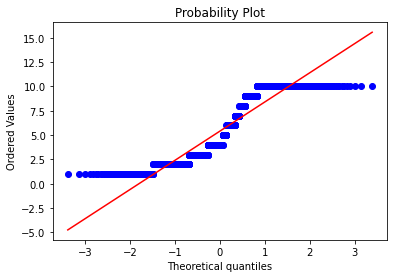

Estadístico 0.8661680221557617
P_Value 5.732467070581263e-38


In [8]:
#Función pra graficar los valores de las variables de entrada y calcular el p_value
def grafica_caract(caracteristica):
  stats.probplot(caracteristica, dist="norm", plot=pylab)
  pylab.show()
  estadistico, p_value = shapiro(caracteristica)
  print("Estadístico", estadistico)
  print("P_Value", p_value)

grafica_caract(df.estilo)


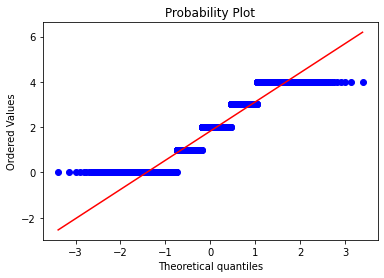

Estadístico 0.8948257565498352
P_Value 1.2880264683662946e-34


In [9]:
grafica_caract(df.personalidad)

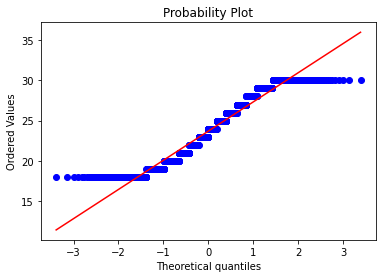

Estadístico 0.944227933883667
P_Value 1.4432620098910577e-26


In [10]:
grafica_caract(df.edad)

In [11]:
#CORRELACION Y SIGNIFICANCIA
#El método spearman se usa cuando no se tiene una distribucción normal
df_corr = df.corr(method='spearman')
df_corr 

,edad,genero,personalidad,estilo
edad,1.000000,0.048626,0.035705,-0.026994
genero,0.048626,1.000000,0.089536,-0.010510
personalidad,0.035705,0.089536,1.000000,0.065220
estilo,-0.026994,-0.010510,0.065220,1.000000


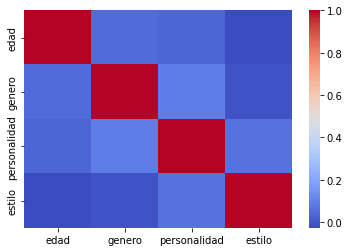

In [12]:
#Gráfica del mapa de calor para la correlación de las características
sns.heatmap(df_corr, 
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap = 'coolwarm')

Si el valor de significancia es mayor a 0.05 entonces no existe una correlación. Por otro lado, si el p_value tiene un valor muy cercano a cero, esas variables tienen un nivel alto de correlación. 

In [13]:
#Matriz de correlaciones entre las variables
corr =pg.pairwise_corr(df, method='spearman')
corr.sort_values(by=['p-unc'])[['X', 'Y', 'n', 'r', 'p-unc']]

,X,Y,n,r,p-unc
3,genero,personalidad,1956,0.089536,0.000073
5,personalidad,estilo,1956,0.065220,0.003905
0,edad,genero,1956,0.048626,0.031517
1,edad,personalidad,1956,0.035705,0.114425
2,edad,estilo,1956,-0.026994,0.232741
4,genero,estilo,1956,-0.010510,0.642247


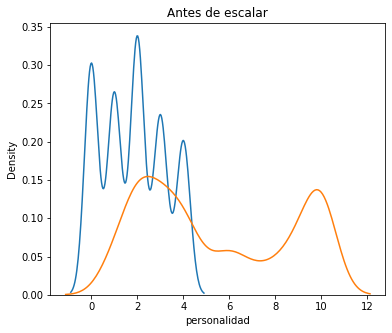

In [14]:
#Gráfica de los datos de personalidad y estilo con los valores originales
fig,(ax1) = plt.subplots(ncols=1, figsize=(6,5))
ax1.set_title('Antes de escalar')
sns.kdeplot(df['personalidad'], ax=ax1)
sns.kdeplot(df['estilo'], ax=ax1)


In [15]:
#Dataset con el que se trabajará para la transformación de los datos
data

,edad,genero,personalidad,estilo
0,25,Masculino,Confiable,5
1,28,Femenino,Animado,4
2,18,Femenino,Animado,6
3,45,Masculino,Extravertido,3
4,21,Masculino,Confiable,3
...,...,...,...,...
2205,26,Femenino,Animado,10
2206,29,Femenino,Animado,1
2207,22,Masculino,Extravertido,8
2208,22,Masculino,Responsable,4


In [16]:
#Técnica de Binning adaptativo para la segmentación de la edad
bins = np.linspace(17,30,6)
labels = ['rang1', 'rang2', 'rang3','rang4','rang5']
data['edad'] = pd.cut(data['edad'], bins, labels=labels)

print(bins)
print(data)

[17.  19.6 22.2 24.8 27.4 30. ]
       edad     genero  personalidad  estilo
0     rang4  Masculino     Confiable       5
1     rang5   Femenino       Animado       4
2     rang1   Femenino       Animado       6
3       NaN  Masculino  Extravertido       3
4     rang2  Masculino     Confiable       3
...     ...        ...           ...     ...
2205  rang4   Femenino       Animado      10
2206  rang5   Femenino       Animado       1
2207  rang2  Masculino  Extravertido       8
2208  rang2  Masculino   Responsable       4
2209  rang1  Masculino     Confiable       7

[2210 rows x 4 columns]


In [17]:
check_null(data)

True
edad            254
genero            0
personalidad      0
estilo            0
dtype: int64


In [18]:
#Eliminación de los datos nulos en la columna de "edad"
data = data[~data['edad'].isnull()].copy()
data

,edad,genero,personalidad,estilo
0,rang4,Masculino,Confiable,5
1,rang5,Femenino,Animado,4
2,rang1,Femenino,Animado,6
4,rang2,Masculino,Confiable,3
5,rang2,Masculino,Animado,10
...,...,...,...,...
2205,rang4,Femenino,Animado,10
2206,rang5,Femenino,Animado,1
2207,rang2,Masculino,Extravertido,8
2208,rang2,Masculino,Responsable,4


In [19]:
#Eliminación de las variables que no están correlacionadas al estilo
data=data.drop(['edad','genero'], axis=1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 2209
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   personalidad  1956 non-null   object
 1   estilo        1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


AxesSubplot(0.125,0.125;0.775x0.755)


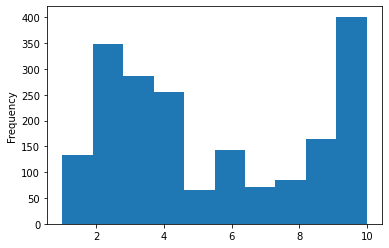

In [21]:
#Gráfica de frecuencia de las opciones de salida de Y (estilos de vestir) 
histogram = data.estilo.plot.hist()
print(histogram)
plt.show()

In [22]:
#Eliminación de los datos poco recurrentes y definición de una salida binaria
indexNames = data[ (data['estilo'] >= 3) & (data['estilo'] <= 9)].index
indexNames1 = data[ (data['estilo'] == 1)].index
data.drop(indexNames , inplace=True)
data.drop(indexNames1 , inplace=True)
print(data)

     personalidad  estilo
5         Animado      10
6     Responsable      10
11          Serio      10
12          Serio      10
13        Animado      10
...           ...     ...
2197  Responsable       2
2200    Confiable       2
2201      Animado      10
2204      Animado      10
2205      Animado      10

[749 rows x 2 columns]


In [23]:
#Técnica de One Hot Encoding para transformar los datos categóricos a numéricos
one_hot_Personalidad = pd.get_dummies(data.personalidad )

In [24]:
#Normalización de la salida para definir un solo rango de valores en el dataset
y = data[['estilo']]
y_norm = (y - y.min()) / ( y.max() - y.min())

In [25]:
#Concatenación de las variables transformadas
data = pd.concat([one_hot_Personalidad, y_norm ], axis=1)

In [26]:
data

,Animado,Confiable,Extravertido,Responsable,Serio,estilo
5,1,0,0,0,0,1.0
6,0,0,0,1,0,1.0
11,0,0,0,0,1,1.0
12,0,0,0,0,1,1.0
13,1,0,0,0,0,1.0
...,...,...,...,...,...,...
2197,0,0,0,1,0,0.0
2200,0,1,0,0,0,0.0
2201,1,0,0,0,0,1.0
2204,1,0,0,0,0,1.0


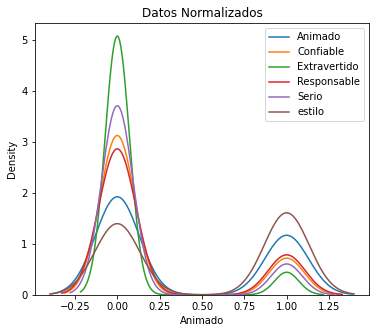

In [27]:
#Gráfica de los datos Normalizados
fig,(ax1) = plt.subplots(ncols=1, figsize=(6,5))
ax1.set_title('Datos Normalizados')
sns.kdeplot(data['Animado'], ax=ax1)
sns.kdeplot(data['Confiable'], ax=ax1)
sns.kdeplot(data['Extravertido'], ax=ax1)
sns.kdeplot(data['Responsable'], ax=ax1)
sns.kdeplot(data['Serio'], ax=ax1)
sns.kdeplot(data['estilo'], ax=ax1)

plt.legend(labels=["Animado", "Confiable", "Extravertido", "Responsable", "Serio", "estilo"])

In [28]:
#Exportación del nuevo dataset a un archivo plano
data.to_excel("DatosLimpios.xlsx")

In [29]:
#Importación del nuevo dataset para implementación del modelo SVM
datos = pd.read_excel("DatosLimpios.xlsx", names=['Animado', 'Confiable', 'Extravertido', 'Responsable', 'Serio','estilo'])
datos

,Animado,Confiable,Extravertido,Responsable,Serio,estilo
5,1,0,0,0,0,1
6,0,0,0,1,0,1
11,0,0,0,0,1,1
12,0,0,0,0,1,1
13,1,0,0,0,0,1
...,...,...,...,...,...,...
2197,0,0,0,1,0,0
2200,0,1,0,0,0,0
2201,1,0,0,0,0,1
2204,1,0,0,0,0,1


In [30]:
#Asignación de valores a X e Y
datos = datos.values
X = datos[:, :-1]
y = datos[:,-1]

In [31]:
#División del dataset entre los datos de entrenamiento y los de testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101)

In [32]:
#Función para retornar cada modelo de kernel en SVM
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto")

In [33]:
#Recorrido del modelo con cada uno de los kernels
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

    #Designación del kernel
    svclassifier = getClassifier(i) 

    #Entrenamiento del modelo
    svclassifier.fit(X_train, y_train)

    #Evaluación del modelo 
    y_pred = svclassifier.predict(X_test)
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.54      1.00      0.70       121

    accuracy                           0.54       225
   macro avg       0.27      0.50      0.35       225
weighted avg       0.29      0.54      0.38       225

Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.67      0.58      0.62        98
           1       0.71      0.78      0.74       127

    accuracy                           0.69       225
   macro avg       0.69      0.68      0.68       225
weighted avg       0.69      0.69      0.69       225

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       105
           1       0.70      0.82      0.76       120

    accuracy                           0.72       225
   macro avg       0.73      0.71      0.71     

In [34]:
#Definición de los hiper parámetros para mejorar el accuracy del modelo
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['sigmoid','rbf','poly']}

In [35]:
#Entrenamiento del modelo con los hiper parámetros definidos
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['sigmoid', 'rbf', 'poly']},
             verbose=2)

In [36]:
#Definición de las mejores opciones para los hiper parámetros
print(grid.best_estimator_)

SVC(C=1, gamma=1, kernel='sigmoid')


In [37]:
#Entrenamiento del modelo con las opciones obtenidas en el paso anterior
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[62 40]
 [30 93]]
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       102
           1       0.70      0.76      0.73       123

    accuracy                           0.69       225
   macro avg       0.69      0.68      0.68       225
weighted avg       0.69      0.69      0.69       225



In [38]:
#Evaluación del modelo en datos del entrenamiento
print("precisión entranamiento: {0: .2f}".format(
        grid.score(X_train, y_train)))

precisión entranamiento:  0.72


In [39]:
#Evaluación del modelo en datos de testeo
print("precisión entranamiento: {0: .2f}".format(
        grid.score(X_test, y_test)))

precisión entranamiento:  0.69


In [40]:
##Validación cruzada con el algoritmo SVM aplicando hiper parámetros)
a = cross_val_score(grid, X_train, y_train, cv = 3, scoring="accuracy")
print("Accuracy: {0: .2f}".format(a.mean()))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

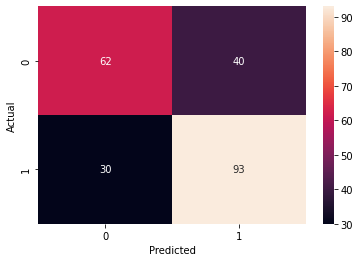

In [41]:
#Gráfica de la matriz de confusión para evaluación de nuestro modelo
confusion_matrix = pd.crosstab(y_test, grid_predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [42]:
#Evaluación de las métricas del modelo SVM
#Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, grid_predictions))

#Precision
print("Precision:", metrics.precision_score(y_test, grid_predictions))

#Recall
print("Recall:", metrics.recall_score(y_test, grid_predictions))

Accuracy: 0.6888888888888889
Precision: 0.6992481203007519
Recall: 0.7560975609756098


In [43]:
#Evaluación del modelo con una nueva entrada
X_new = pd.DataFrame({'Animado': [1], 'Confiable': [0], 'Extravertido': [0], 'Responsable': [0], 'Serio': [0]})
print("El array 1 corresponde al estilo casual y el 0 corresponde al estilo modesto\n")
print("El estilo de vestir es:", grid.predict(X_new))

El array 1 corresponde al estilo casual y el 0 corresponde al estilo modesto

El estilo de vestir es: [1]
